In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import Preprocessing
import DataProcessing
import model
import numpy as np
import utils
data = Preprocessing.load_data('data/rt_iot2022', target_col='Attack_type')

In [21]:
Preprocessing.check_types(data,"object")

proto
service
Attack_type


In [22]:
data = Preprocessing.delete_columns(data, ["Unnamed: 0",'service'])
data = data.loc[:, data.columns.notna()]
data = Preprocessing.one_hot_encode(data, ['proto'])
data = Preprocessing.label_encode(data, ['Attack_type'])
print(data.head(5))

   id.orig_p  id.resp_p  flow_duration  fwd_pkts_tot  bwd_pkts_tot  \
0      38667       1883      32.011598             9             5   
1      51143       1883      31.883584             9             5   
2      44761       1883      32.124053             9             5   
3      60893       1883      31.961063             9             5   
4      51087       1883      31.902362             9             5   

   fwd_data_pkts_tot  bwd_data_pkts_tot  fwd_pkts_per_sec  bwd_pkts_per_sec  \
0                  3                  3          0.281148          0.156193   
1                  3                  3          0.282277          0.156821   
2                  3                  3          0.280164          0.155647   
3                  3                  3          0.281593          0.156440   
4                  3                  3          0.282111          0.156728   

   flow_pkts_per_sec  ...      idle.max      idle.tot      idle.avg  idle.std  \
0           0.437341  .

In [23]:
# Tìm các cột không phải là số (numeric)
non_numeric_cols = data.select_dtypes(exclude=["number"]).columns.tolist()
print("Các cột không phải kiểu số:")
print(non_numeric_cols)


Các cột không phải kiểu số:
['proto_tcp', 'proto_udp']


In [24]:
#Tách cột target ra khỏi dữ liệu
X, y = data.drop('Attack_type', axis=1), data['Attack_type']
X,_ = Preprocessing.scale_data(X)
# X_balanced, y_balanced = Preprocessing.apply_smote(X, y)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [25]:
#chưa áp dụng smotesmote
X_train_nsm, X_test_nsm, y_train_nsm, y_test_nsm = train_test_split(X,y, test_size=0.2, random_state=42)

#áp dụng smote
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_sm, y_train_sm = Preprocessing.apply_smote(X_train_sm, y_train_sm)

In [26]:
# Preprocessing.plot_heatmap(X_train_sm[list['Feature']], y_train_sm,'Attack_type')

In [27]:
# Preprocessing.plot_heatmap(X_train[list['Feature']].drop(dropped_columns, axis=1), y_train,'Attack_type')

Train với dữ liệu chưa giảm chiều

In [28]:
# x2 = X_train[list['Feature']].drop(dropped_columns, axis=1)

In [29]:
# print(len(X_train.columns))

Train với dữ liệu đã giảm chiều

c:\Users\QUIN\Desktop\PPNCKH\DataProcessing.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Importance', y='Feature', palette='viridis')


40


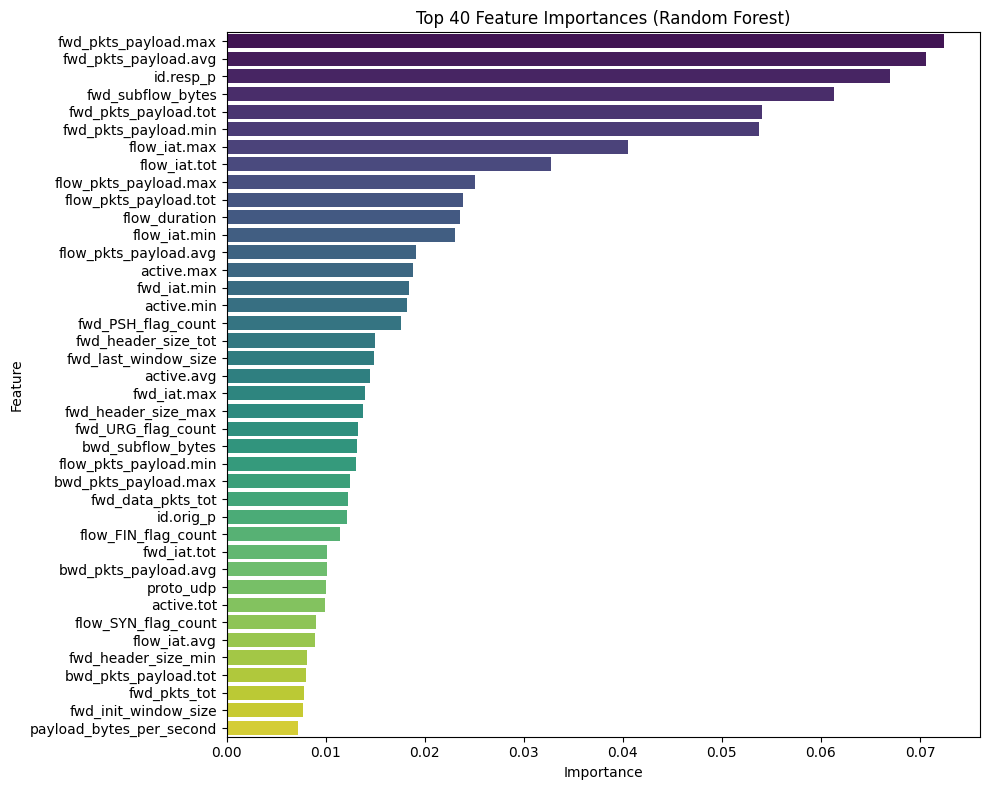

In [30]:
# Xử lý dữ liệu
list = DataProcessing.select_feature(X_train_sm, y_train_sm)
print(len(list))

In [31]:
X_train_sm = X_train_sm[list['Feature']]
df_reduced, dropped_columns = DataProcessing.remove_highly_correlated_columns(X_train_sm[list['Feature']], threshold=0.8)

Các cột bị loại bỏ: ['flow_iat.avg', 'flow_duration', 'fwd_iat.tot', 'fwd_pkts_payload.min', 'bwd_pkts_payload.max', 'fwd_init_window_size', 'fwd_data_pkts_tot', 'fwd_iat.max', 'bwd_pkts_payload.avg', 'bwd_pkts_payload.tot', 'flow_pkts_payload.max', 'bwd_subflow_bytes', 'flow_SYN_flag_count', 'active.avg', 'fwd_pkts_tot', 'active.min', 'fwd_header_size_min']


In [32]:
X_train_sm_dr = df_reduced
X_test_sm_dr = X_test_sm[list['Feature']].drop(dropped_columns, axis=1)
y_train_sm_dr = y_train_sm.copy()
y_test_sm_dr = y_test_sm.copy()

In [34]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

Train mô hỉnh tinh chỉnh.

XGBoost

c:\Users\QUIN\anaconda3\envs\PPNKCH\lib\site-packages\xgboost\training.py:183: UserWarning: [09:08:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters for XGBoost: {'subsample': 1.0, 'scale_pos_weight': np.float64(151.524), 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
XGBoost Classification Report:
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      1595
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00     18898
           3       1.00      1.00      1.00       870
           4       0.83      0.83      0.83         6
           5       0.67      1.00      0.80         2
           6       1.00      1.00      1.00       393
           7       1.00      1.00      1.00       220
           8       0.99      1.00      0.99       485
           9       0.99      1.00      1.00       381
          10       0.99      0.99      0.99      1617
          11       0.98      1.00      0.99        57

    accuracy                           1.00     24624
   macro avg  